<a href="https://colab.research.google.com/github/esma-nur/Anomaly-Detection-Anomalib-Library/blob/main/vgg16_eksikliklerVarduzenlenecek_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from PIL import Image
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

In [71]:
import tensorflow as tf
import os
import numpy as np
import glob
import random
import cv2
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, BatchNormalization,Conv2DTranspose, concatenate,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras import backend as K

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
# Define the paths to the folders

base_dir = "/content/drive/MyDrive/mvtec-wood/wood"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
gt_dir = os.path.join(base_dir, "ground_truth")

# Initialize lists to store data for DataFrame
data = []

# Handle "good" folder
# Gather images from "train" folder
train_good_dir = os.path.join(train_dir, "good")
if os.path.exists(train_good_dir):
    train_good_images = os.listdir(train_good_dir)
    for img_name in train_good_images:
        img_path = os.path.join(train_good_dir, img_name)
        mask_path = ""  # No mask for "good" category in train
        category = "good"
        mask = 0
        data.append([img_path, mask_path, category, mask])

# Gather images from "test/good" folder
test_good_dir = os.path.join(test_dir, "good")
if os.path.exists(test_good_dir):
    test_good_images = os.listdir(test_good_dir)
    for img_name in test_good_images:
        img_path = os.path.join(test_good_dir, img_name)
        mask_path = ""  # No mask for "good" category in test
        category = "good"
        mask = 0
        data.append([img_path, mask_path, category, mask])
# Handle ground truth folders
gt_categories = ["color", "combined", "hole", "liquid", "scratch"]
for category in gt_categories:
    test_category_dir = os.path.join(test_dir, category)
    gt_category_dir = os.path.join(gt_dir, category)
    if os.path.exists(test_category_dir) and os.path.exists(gt_category_dir):
        test_images = os.listdir(test_category_dir)
        for img_name in test_images:
            img_path = os.path.join(test_category_dir, img_name)
            mask_name = img_name.split('.')[0] + "_mask.png"
            mask_path = os.path.join(gt_category_dir, mask_name)
            mask_category = category
            mask = 1
            data.append([img_path, mask_path, mask_category, mask])


# Create a DataFrame
df = pd.DataFrame(data, columns=["image_path", "mask_path", "categories", "mask"])

# Display the DataFrame
print(df)

                                            image_path  \
0    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
1    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
2    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
3    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
4    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
..                                                 ...   
321  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
322  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
323  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
324  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
325  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   

                                             mask_path categories  mask  
0                                                            good     0  
1                                                            good     0  
2                                                            good     0  
3      

In [61]:
import pandas as pd
from PIL import Image
import numpy as np
import os

# Define image dimensions
width, height = 1024, 1024

# Create a solid black image using NumPy
black_image_array = np.zeros((height, width, 3), dtype=np.uint8)
black_image = Image.fromarray(black_image_array)

# Define the directory to save the black image
save_directory = "/content/drive/MyDrive/mvtec-wood/good-masks"

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Define your DataFrame 'df' here
df = pd.DataFrame(data, columns=["image_path", "mask_path", "categories", "mask"])

# Fill the blank values in 'mask_path' column with the black image
for index, row in df.iterrows():
    if pd.isnull(row['mask_path']) or row['mask_path'] == '':
        black_image_path = os.path.join(save_directory, f'black_image_{index}.png')  # Unique path for each image
        black_image.save(black_image_path)
        df.at[index, 'mask_path'] = black_image_path

print("DataFrame after filling blank values in 'mask_path' column:")
print(df)


DataFrame after filling blank values in 'mask_path' column:
                                            image_path  \
0    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
1    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
2    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
3    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
4    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
..                                                 ...   
321  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
322  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
323  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
324  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
325  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   

                                             mask_path categories  mask  
0    /content/drive/MyDrive/mvtec-wood/good-masks/b...       good     0  
1    /content/drive/MyDrive/mvtec-wood/good-masks/b...       good     0  
2    /content/drive/M

In [73]:
# Define your DataFrame 'df' here
df = pd.DataFrame(data, columns=["image_path", "mask_path", "categories", "mask"])

# Fill the blank values in 'mask_path' column with the black image
for index, row in df.iterrows():
    if pd.isnull(row['mask_path']) or row['mask_path'] == '':
        black_image_path = os.path.join(save_directory, f'black_image_{index}.png')  # Unique path for each image
        black_image.save(black_image_path)
        df.at[index, 'mask_path'] = black_image_path

print("DataFrame after filling blank values in 'mask_path' column:")
print(df)


DataFrame after filling blank values in 'mask_path' column:
                                            image_path  \
0    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
1    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
2    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
3    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
4    /content/drive/MyDrive/mvtec-wood/wood/train/g...   
..                                                 ...   
321  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
322  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
323  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
324  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
325  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   

                                             mask_path categories  mask  
0    /content/drive/MyDrive/mvtec-wood/wood/train/b...       good     0  
1    /content/drive/MyDrive/mvtec-wood/wood/train/b...       good     0  
2    /content/drive/M

In [62]:
import os

# Define the directory to save the CSV file
save_directory = "/content/drive/MyDrive/mvtec-wood/wood/train/"

# Define your DataFrame 'df' here
df = pd.DataFrame(data, columns=["image_path", "mask_path", "categories", "mask"])

# Fill the blank values in 'mask_path' column with the black image
for index, row in df.iterrows():
    if pd.isnull(row['mask_path']) or row['mask_path'] == '':
        black_image_path = os.path.join(save_directory, f'black_image_{index}.png')  # Unique path for each image
        black_image.save(black_image_path)
        df.at[index, 'mask_path'] = black_image_path

# Save DataFrame as a CSV file in the 'wood' directory
os.makedirs(save_directory, exist_ok=True)  # Create the directory if it doesn't exist
csv_file_path = os.path.join(save_directory, 'good_mask_dataframe.csv')
df.to_csv(csv_file_path, index=False)  # index=False to exclude row indices in the CSV file

print(f"DataFrame saved as '{csv_file_path}'")



DataFrame saved as '/content/drive/MyDrive/mvtec-wood/wood/train/good_mask_dataframe.csv'


In [74]:
df.head()

image_path  \
0  /content/drive/MyDrive/mvtec-wood/wood/train/g...   
1  /content/drive/MyDrive/mvtec-wood/wood/train/g...   
2  /content/drive/MyDrive/mvtec-wood/wood/train/g...   
3  /content/drive/MyDrive/mvtec-wood/wood/train/g...   
4  /content/drive/MyDrive/mvtec-wood/wood/train/g...   

                                           mask_path categories  mask  
0  /content/drive/MyDrive/mvtec-wood/wood/train/b...       good     0  
1  /content/drive/MyDrive/mvtec-wood/wood/train/b...       good     0  
2  /content/drive/MyDrive/mvtec-wood/wood/train/b...       good     0  
3  /content/drive/MyDrive/mvtec-wood/wood/train/b...       good     0  
4  /content/drive/MyDrive/mvtec-wood/wood/train/b...       good     0

In [75]:
df.shape

(326, 4)

In [33]:
df['categories'].value_counts()

categories
good        266
scratch      21
combined     11
hole         10
liquid       10
color         8
Name: count, dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  326 non-null    object
 1   mask_path   326 non-null    object
 2   categories  326 non-null    object
 3   mask        326 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.3+ KB


In [35]:
df['mask'].value_counts()

mask
0    266
1     60
Name: count, dtype: int64

Data Augmentation

In [76]:
# Get the dataframe containing Woods defected which have masks associated with them.
wood_df_mask = df[df['mask']==1]
wood_df_mask.shape

(60, 4)

In [77]:
wood_df_mask

image_path  \
266  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
267  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
268  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
269  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
270  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
271  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
272  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
273  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
274  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
275  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
276  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
277  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
278  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
279  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
280  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
281  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
282  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
283  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
284  /content/drive/MyDrive/mvtec-wood/wood/test/co...   
285  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
286  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
287  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
288  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
289  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
290  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
291  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
292  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
293  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
294  /content/drive/MyDrive/mvtec-wood/wood/test/ho...   
295  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
296  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
297  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
298  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
299  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
300  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
301  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
302  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
303  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
304  /content/drive/MyDrive/mvtec-wood/wood/test/li...   
305  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
306  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
307  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
308  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
309  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
310  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
311  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
312  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
313  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
314  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
315  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
316  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
317  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
318  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
319  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
320  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
321  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
322  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
323  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
324  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   
325  /content/drive/MyDrive/mvtec-wood/wood/test/sc...   

                                             mask_path categories  mask  
266  /content/drive/MyDrive/mvtec-wood/wood/ground_...      color     1  
267  /content/drive/MyDrive/mvtec-wood/wood/ground_...      color     1  
268  /content/drive/MyDrive/mvtec-wood/wood/ground_...      color     1  
269  /content/drive/MyDrive/mvtec-wood/wood/ground_...      color     1  
270  /content/drive/MyDrive/mvtec-wood/wood/ground_...      color     1  
271  /content/drive/MyDrive/mvtec-wood/wood/ground_...      c

In [ ]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import os
import numpy as np
from PIL import Image


# Define the augmentation transformations
augmentations = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.5),
    A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.VerticalFlip(p=0.5),

    A.HueSaturationValue(p=0.5, hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20),
    A.Perspective(p=0.5),
    ToTensorV2(),
])


# Create directories to save augmented images and masks
output_image_dir = "/content/drive/MyDrive/mvtec-wood/aug/image/"
output_mask_dir = "/content/drive/MyDrive/mvtec-wood/aug/mask/"
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# Initialize a list to store augmented data
augmented_data = []

# Loop through each row in wood_df_mask
for index, row in wood_df_mask.iterrows():
    image_path = row['image_path']
    mask_path = row['mask_path']
    category = row['categories']

    # Set 'mask' column to 1
    wood_df_mask.at[index, 'mask'] = 1

    # Load the image and mask
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))

    # Initialize a list to store augmented images and masks
    augmented_images = []
    augmented_masks = []

    # Apply augmentations to the original image and mask multiple times
    for _ in range(7):  # Change 4 to the desired number of augmentations per image
        augmented = augmentations(image=image, mask=mask)
        augmented_image = augmented['image']
        augmented_mask = augmented['mask']

        # Convert PyTorch tensor to NumPy array
        augmented_image = augmented_image.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC

        # Ensure pixel values are in the range [0, 1] (undo normalization)
        augmented_image = augmented_image.astype(np.float32) / 255.0

        augmented_mask = augmented_mask.squeeze().cpu().numpy()  # Squeeze channel dimension
        augmented_mask[augmented_mask != 0] = 1  # Set all non-zero values to 1
        augmented_mask = (augmented_mask * 255).astype(np.uint8)

        # Save augmented images and masks
        image_filename = f'{category}_{index}_aug_{_}.png'
        mask_filename = f'{category}_{index}_aug_mask_{_}.png'
        augmented_image_path = os.path.join(output_image_dir, image_filename)
        augmented_mask_path = os.path.join(output_mask_dir, mask_filename)

        Image.fromarray((augmented_image * 255).astype(np.uint8)).save(augmented_image_path)  # Convert back to uint8
        Image.fromarray(augmented_mask).save(augmented_mask_path)

        # Append augmented data to the list
        augmented_data.append([augmented_image_path, augmented_mask_path, category, 1])

# Shuffle the augmented data (if needed)
np.random.shuffle(augmented_data)

# Convert augmented_data list to a DataFrame (if needed)
augmented_df = pd.DataFrame(augmented_data, columns=['image_path', 'mask_path', 'category', 'mask'])



In [80]:
# Create a DataFrame for augmented data
augmented_df = pd.DataFrame(augmented_data, columns=["image_path", "mask_path", "categories", "mask"])

# Concatenate the original DataFrame 'df' with the augmented DataFrame
concatenated_df = pd.concat([df, augmented_df], ignore_index=True)

# Display the concatenated DataFrame
concatenated_df.tail(50)

NameError: name 'augmented_data' is not defined

In [81]:
concatenated_df.tail(50)

image_path  \
696  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
697  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
698  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
699  /content/drive/MyDrive/mvtec-wood/aug/image/ho...   
700  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
701  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
702  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
703  /content/drive/MyDrive/mvtec-wood/aug/image/li...   
704  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
705  /content/drive/MyDrive/mvtec-wood/aug/image/li...   
706  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
707  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
708  /content/drive/MyDrive/mvtec-wood/aug/image/li...   
709  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
710  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
711  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
712  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
713  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
714  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
715  /content/drive/MyDrive/mvtec-wood/aug/image/ho...   
716  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
717  /content/drive/MyDrive/mvtec-wood/aug/image/li...   
718  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
719  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
720  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
721  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
722  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
723  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
724  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
725  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
726  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
727  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
728  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
729  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
730  /content/drive/MyDrive/mvtec-wood/aug/image/ho...   
731  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
732  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
733  /content/drive/MyDrive/mvtec-wood/aug/image/li...   
734  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
735  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
736  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
737  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
738  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
739  /content/drive/MyDrive/mvtec-wood/aug/image/ho...   
740  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
741  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
742  /content/drive/MyDrive/mvtec-wood/aug/image/co...   
743  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
744  /content/drive/MyDrive/mvtec-wood/aug/image/sc...   
745  /content/drive/MyDrive/mvtec-wood/aug/image/ho...   

                                             mask_path categories  mask  
696  /content/drive/MyDrive/mvtec-wood/aug/mask/col...      color     1  
697  /content/drive/MyDrive/mvtec-wood/aug/mask/scr...    scratch     1  
698  /content/drive/MyDrive/mvtec-wood/aug/mask/scr...    scratch     1  
699  /content/drive/MyDrive/mvtec-wood/aug/mask/hol...       hole     1  
700  /content/drive/MyDrive/mvtec-wood/aug/mask/com...   combined     1  
701  /content/drive/MyDrive/mvtec-wood/aug/mask/col...      color     1  
702  /content/drive/MyDrive/mvtec-wood/aug/mask/com...   combined     1  
703  /content/drive/MyDrive/mvtec-wood/aug/mask/liq...     liquid     1  
704  /content/drive/MyDrive/mvtec-wood/aug/mask/scr...    scratch     1  
705  /content/drive/MyDrive/mvtec-wood/aug/mask/liq...     liquid     1  
706  /content/drive/MyDrive/mvtec-wood/aug/mask/scr...    scratch     1  
707  /content/drive/MyDrive/mvtec-wood/aug/mask/scr...    scratch     1  
708  /content/drive/MyDrive/mvtec-wood/aug/mask/liq...     liquid     1  
709  /content/drive/MyDrive/mvtec-wood/aug/mask/c

In [ ]:
# Birleştirilmiş veri çerçevesini CSV dosyasına kaydetme
concatenated_df.to_csv('/content/drive/MyDrive/mvtec-wood/wood/after_augmented_veri.csv', sep=';', index=False)

print("Birleştirilmiş veri çerçevesi 'birlestirilmis_veri.csv' adlı dosyaya kaydedildi.")


Birleştirilmiş veri çerçevesi 'birlestirilmis_veri.csv' adlı dosyaya kaydedildi.


In [79]:
from google.colab import data_table
import pandas as pd

# CSV dosyasını DataFrame'e yükleme
concatenated_df = pd.read_csv('/content/drive/MyDrive/mvtec-wood/wood/after_augmented_veri.csv', sep=';')

# DataFrame'i data table olarak gösterme
data_table.DataTable(concatenated_df)

In [82]:
concatenated_df['mask'].value_counts()

mask
1    480
0    266
Name: count, dtype: int64

In [83]:
concatenated_df.isnull().sum()

image_path    0
mask_path     0
categories    0
mask          0
dtype: int64

In [51]:
# Before Data Augmentation
df['categories'].value_counts()

categories
good        266
scratch      21
combined     11
hole         10
liquid       10
color         8
Name: count, dtype: int64

In [84]:
# After Data Augmentation
concatenated_df['categories'].value_counts()


categories
good        266
scratch     168
combined     88
hole         80
liquid       80
color        64
Name: count, dtype: int64

PERFORM DATA VISUALIZATION

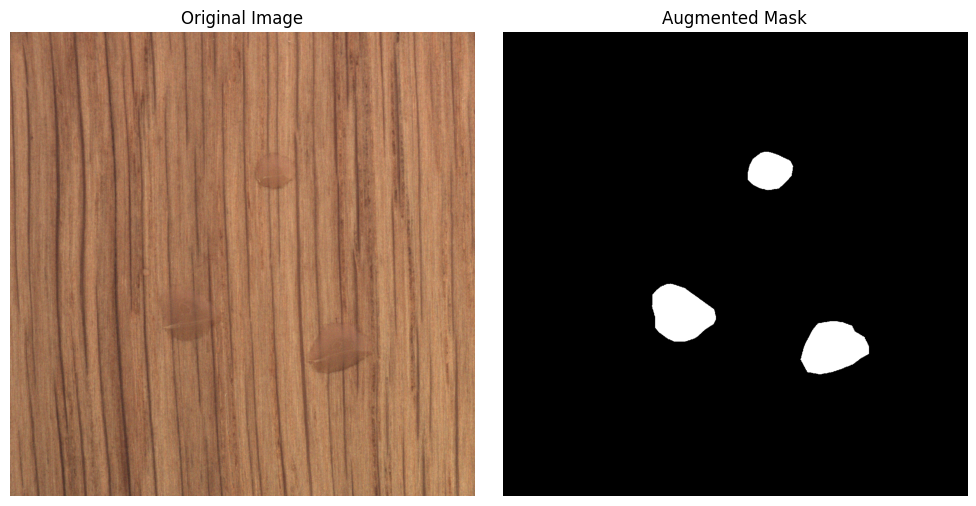

In [85]:
import matplotlib.pyplot as plt

# Define the index you want to visualize
index_to_visualize = 362

# Get the image and mask paths for the selected index
image_path = concatenated_df.loc[index_to_visualize, 'image_path']
mask_path = concatenated_df.loc[index_to_visualize, 'mask_path']

# Load the image and mask using PIL
image = Image.open(image_path)
mask = Image.open(mask_path)

# Create a subplot to display the image and mask side by side
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

# Display the augmented mask
plt.subplot(1, 2, 2)
plt.title('Augmented Mask')
plt.imshow(mask, cmap='gray')  # Use 'gray' colormap for grayscale masks
plt.axis('off')

# Show the plots
plt.tight_layout()
plt.show()

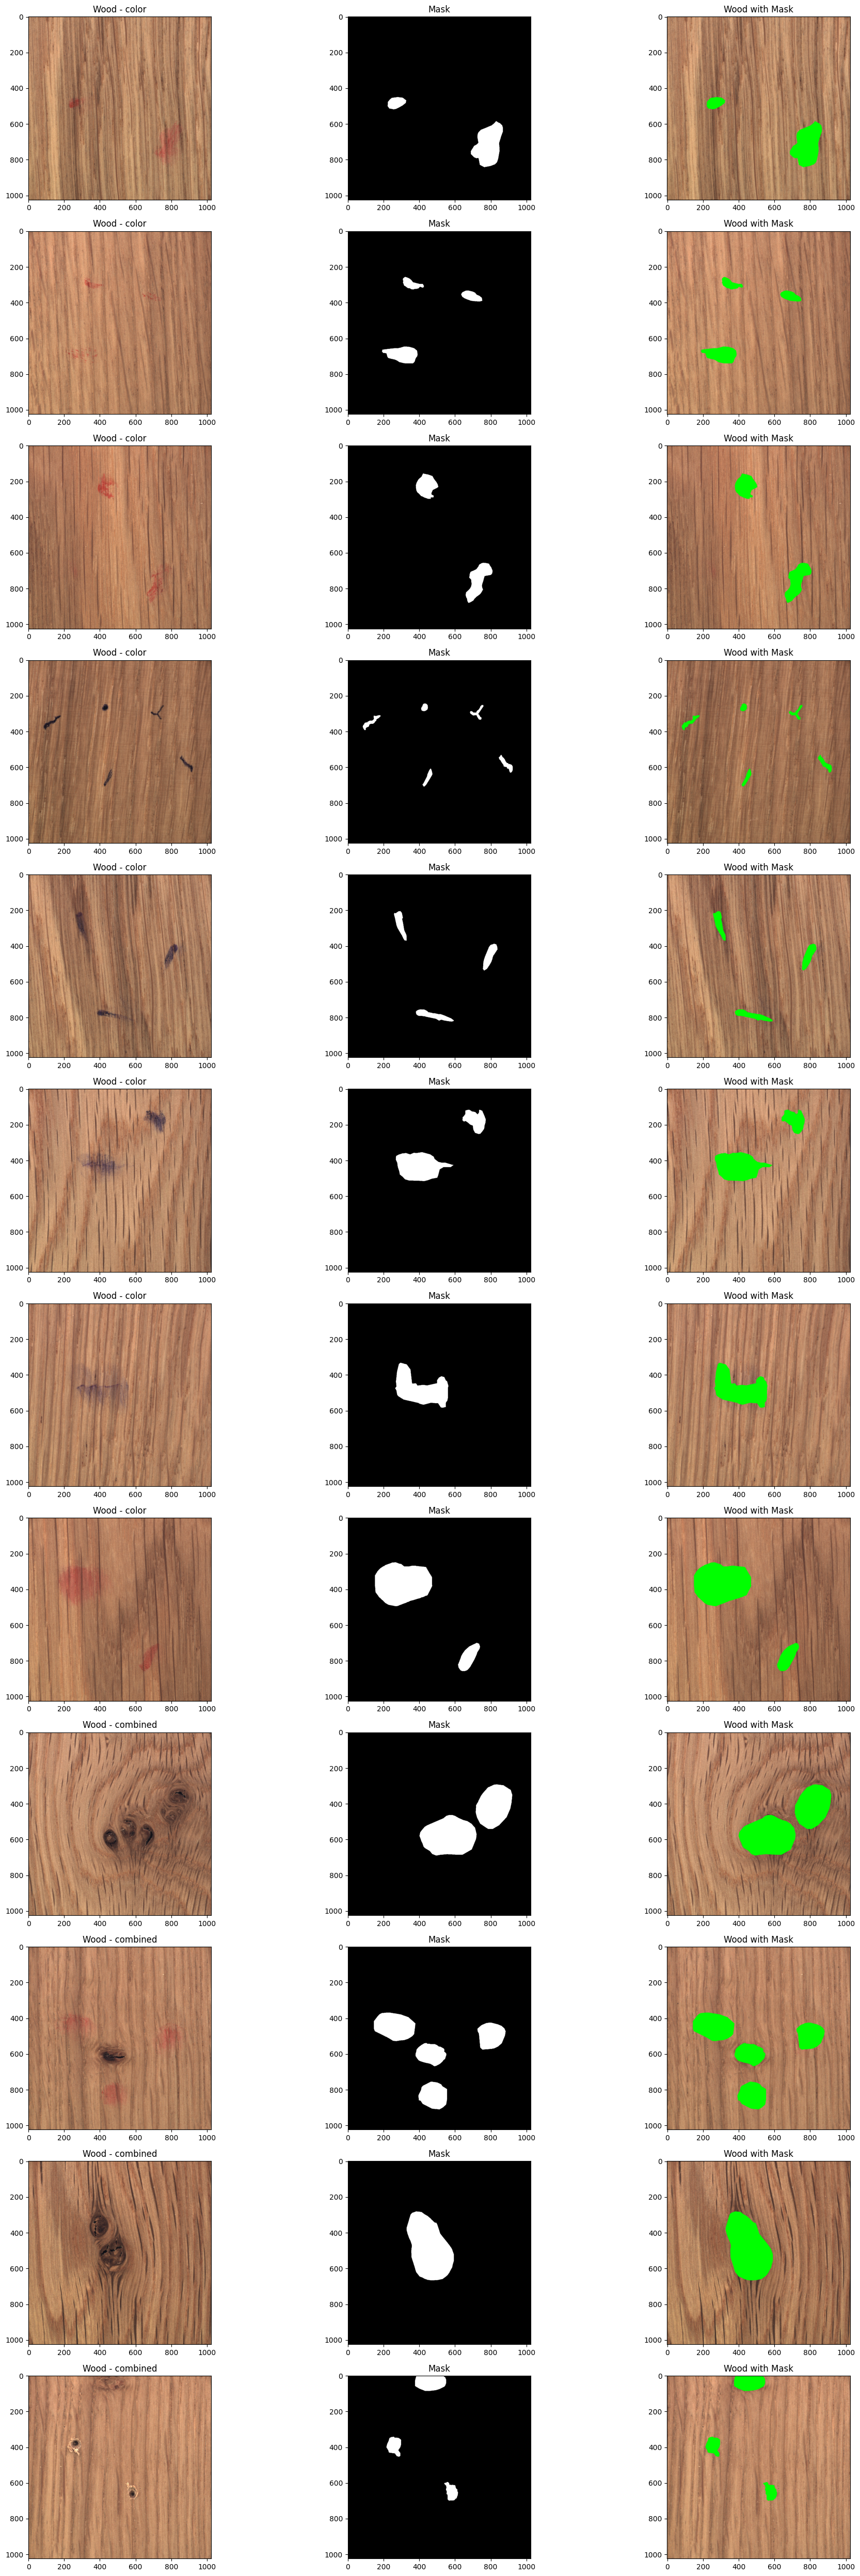

In [86]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(df)):
  if concatenated_df['mask'][i] ==1 and count <12:
    img = io.imread(concatenated_df.image_path[i])
    axs[count][0].title.set_text("Wood - " + str(concatenated_df['categories'][i]))
    axs[count][0].imshow(img)

    mask = io.imread(concatenated_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')


    img[mask == 255] = (0, 255, 0)
    axs[count][2].title.set_text('Wood with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()

TRAIN A CLASSIFIER MODEL TO DETECT IF DEFECTED OR NOT

In [87]:
df_train = concatenated_df
df_train.shape

(746, 4)

In [88]:
df_train['mask'] = df_train['mask'].apply(lambda x: str(x))

In [89]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  746 non-null    object
 1   mask_path   746 non-null    object
 2   categories  746 non-null    object
 3   mask        746 non-null    object
dtypes: object(4)
memory usage: 23.4+ KB


In [90]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size = 0.2)

In [91]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes a validation split of 0.2
datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)


In [92]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(224,224))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(224,224))


Found 477 validated image filenames belonging to 2 classes.
Found 119 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


In [93]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

basemodel = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [94]:
basemodel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [95]:
for layer in basemodel.layers:
  layers.trainable = False

In [96]:
headmodel = basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
output_layer = Dense(2, activation='softmax')(headmodel)
model = Model(inputs=basemodel.input, outputs=output_layer)

In [97]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [98]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

# Specify an absolute path for saving the weights
checkpoint_path = '/content/classifier-vggnet16-weights.hdf5'

# Update the ModelCheckpoint callback
checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

# Use the updated checkpoint path in the fit function
history = model.fit(train_generator, steps_per_epoch=train_generator.n // 16, epochs=50, validation_data=valid_generator, validation_steps=valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.9565 - accuracy: 0.5683
Epoch 1: val_loss improved from inf to 0.68681, saving model to /content/classifier-vggnet16-weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 96s 3s/step - loss: 0.9565 - accuracy: 0.5683 - val_loss: 0.6868 - val_accuracy: 0.6250
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.6030
Epoch 2: val_loss did not improve from 0.68681
29/29 [==============================] - 32s 1s/step - loss: 0.6869 - accuracy: 0.6030 - val_loss: 0.9653 - val_accuracy: 0.5982
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.5401
Epoch 3: val_loss improved from 0.68681 to 0.67887, saving model to /content/classifier-vggnet16-weights.hdf5
29/29 [==============================] - 32s 1s/step - loss: 0.7323 - accuracy: 0.5401 - val_loss: 0.6789 - val_accuracy: 0.6161
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5748
Epoch 4: val_loss improved from 0.67887 to 0.67443, saving model to /content/classifier-vggnet16-weights.hdf5
29/29 [==============================] - 33s 1s/step - loss: 0.6

In [102]:
# save the model architecture to json file

model_json = model.to_json()
with open("classifier-vggnet16-model.json","w") as json_file:
  json_file.write(model_json)

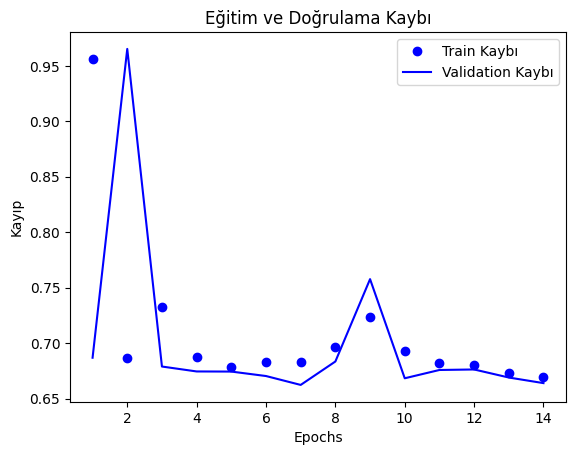

In [103]:
import matplotlib.pyplot as plt

# Eğitim kaybı ve doğruluk değerlerini al
loss = history.history['loss']
val_loss = history.history['val_loss']

# Her epoch için numaraları al
epochs = range(1, len(loss) + 1)

# Eğitim ve doğruluk kaybını çiz
plt.plot(epochs, loss, 'bo', label='Train Kaybı')
plt.plot(epochs, val_loss, 'b', label='Validation Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()

plt.show()


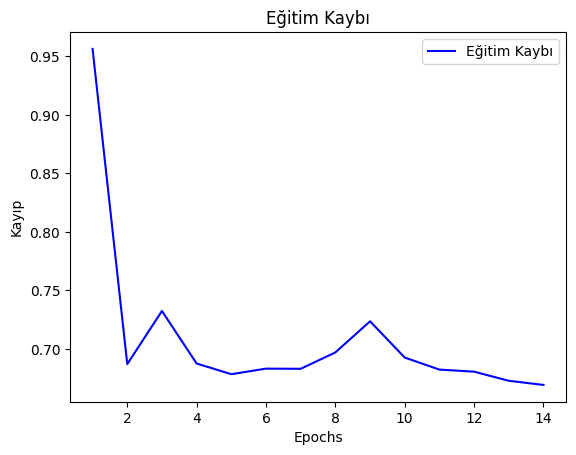

In [104]:
import matplotlib.pyplot as plt

# Eğitim kaybı ve doğruluk değerlerini al
loss = history.history['loss']

# Her epoch için numaraları al
epochs = range(1, len(loss) + 1)

# Eğitim ve doğruluk kaybını çiz
plt.plot(epochs, loss, 'b', label='Eğitim Kaybı')
plt.title('Eğitim Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()

plt.show()

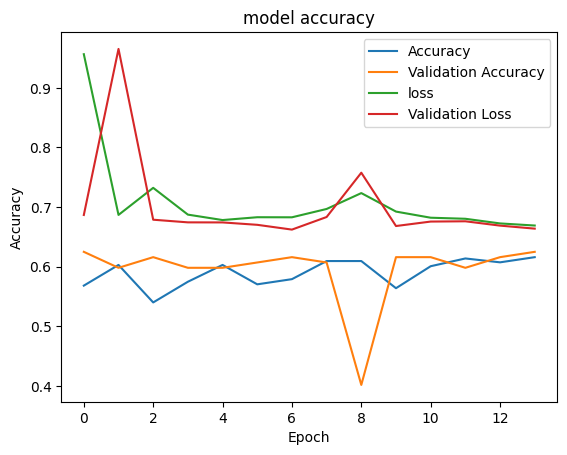

In [105]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

ASSESS TRAINED MODEL PERFORMANCE

In [106]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

9/9 [==============================] - 25s 3s/step


In [107]:
test_predict.shape

(144, 2)

In [108]:
# Obtain the predicted class from the model
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [109]:
predict

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1'], dtype='<U1')

In [110]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

144

In [111]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.7708333333333334

<Axes: >

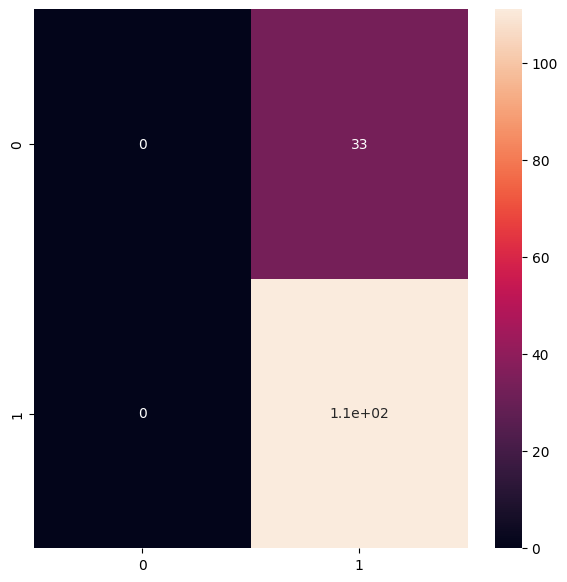

In [112]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [113]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.77      1.00      0.87       111

   micro avg       0.77      0.77      0.77       144
   macro avg       0.39      0.50      0.44       144
weighted avg       0.59      0.77      0.67       144



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BUILD A SEGMENTATION MODEL TO LOCALIZE THE DEFECTION

In [ ]:
concatenated_df['mask'] = concatenated_df['mask'].apply(lambda x: int(x))

In [ ]:
# Get the dataframe containing Woods defected which have masks associated with them.
wood_df_mask = concatenated_df[concatenated_df['mask']==1]
wood_df_mask.shape

(300, 4)

In [ ]:
wood_df_mask

image_path  \
266  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...   
267  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...   
268  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...   
269  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...   
270  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...   
..                                                 ...   
561    C:\Users\reyha\aug\image\combined_279_aug_0.png   
562     C:\Users\reyha\aug\image\scratch_311_aug_3.png   
563    C:\Users\reyha\aug\image\combined_282_aug_1.png   
564       C:\Users\reyha\aug\image\color_267_aug_0.png   
565    C:\Users\reyha\aug\image\combined_277_aug_2.png   

                                             mask_path categories  mask  
266  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...      color     1  
267  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...      color     1  
268  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...      color     1  
269  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...      color     1  
270  C:\Users\reyha\OneDrive\Masaüstü\MVTec-Anomaly...      color     1  
..                                                 ...        ...   ...  
561  C:\Users\reyha\aug\mask\combined_279_aug_mask_...   combined     1  
562  C:\Users\reyha\aug\mask\scratch_311_aug_mask_3...    scratch     1  
563  C:\Users\reyha\aug\mask\combined_282_aug_mask_...   combined     1  
564   C:\Users\reyha\aug\mask\color_267_aug_mask_0.png      color     1  
565  C:\Users\reyha\aug\mask\combined_277_aug_mask_...   combined     1  

[300 rows x 4 columns]

In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(wood_df_mask, test_size=0.2)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# Creating a custom datagenerator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ids, mask, image_dir='./', batch_size=16, img_h=224, img_w=224, shuffle=True):
        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.ids)) / self.batch_size)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_ids = [self.ids[i] for i in indexes]
        list_mask = [self.mask[i] for i in indexes]
        X, y = self.__data_generation(list_ids, list_mask)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids, list_mask):
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        for i in range(len(list_ids)):
            img_path = list_ids[i]
            mask_path = list_mask[i]
            img = io.imread(img_path)
            mask = io.imread(mask_path)
            img = cv2.resize(img, (self.img_h, self.img_w))
            img = np.array(img, dtype=np.float64)
            mask = cv2.resize(mask, (self.img_h, self.img_w))
            mask = np.array(mask, dtype=np.float64)

            img -= img.mean()
            img /= img.std()
            mask -= mask.mean()
            mask /= mask.std()

            X[i,] = img
            y[i,] = np.expand_dims(mask, axis=2)

        y = (y > 0).astype(int)

        return X, y

In [ ]:
def prediction(test, model, model_seg):
    directory = "./"
    mask = []
    image_id = []
    has_mask = []

    for i in test.image_path:
        path = i
        img = io.imread(path)
        img = img * 1.0 / 255.
        img = cv2.resize(img, (224, 224))
        img = np.array(img, dtype=np.float64)
        img = np.reshape(img, (1, 224,224, 3))
        is_defect = model.predict(img)

        if np.argmax(is_defect) == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
            continue

        img = io.imread(path)
        X = np.empty((1, 224,224, 3))
        img = cv2.resize(img, (224,224))
        img = np.array(img, dtype=np.float64)
        img -= img.mean()
        img /= img.std()
        X[0,] = img
        predict = model_seg.predict(X)

        if predict.round().astype(int).sum() == 0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask')
        else:
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)

    return image_id, mask, has_mask

In [ ]:

def tversky(y_true, y_pred):
    smooth = 1.0  # Use a float value for smooth
    y_true_pos = K.flatten(K.cast(y_true, 'float32'))
    y_pred_pos = K.flatten(K.cast(y_pred, 'float32'))
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


#custom loss and metrics functions
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2))  # 128x128 piksel boyutunda toplama yap
    union = K.sum(y_true, axis=(1, 2)) + K.sum(y_pred, axis=(1, 2)) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def F1(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=(1, 2))  # 128x128 piksel boyutunda toplama yap
    precision = (intersection + smooth) / (K.sum(y_pred, axis=(1, 2)) + smooth)
    recall = (intersection + smooth) / (K.sum(y_true, axis=(1, 2)) + smooth)
    f1 = 2 * (precision * recall) / (precision + recall)
    return K.mean(f1)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_coef(y_true, y_pred, smooth = 0.00001):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [ ]:
training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):


  # make a copy of input
  X_copy = X
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (224,224,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(64,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(64,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 128)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 256)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 512)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 1024)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 512)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 256)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 128)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 64)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )

In [ ]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

TRAIN A SEGMENTATION RESUNET MODEL TO LOCALIZE DEFECTION

In [ ]:
from tensorflow import keras
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_seg.compile(optimizer=optimizer, loss=focal_tversky, metrics=[tversky])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = ModelCheckpoint(filepath="mobileNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator, epochs = 100, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/100


NotFoundError: Graph execution error:

Detected at node 'model_1/conv2d_9/Conv2D' defined at (most recent call last):
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\reyha\AppData\Local\Temp\ipykernel_16860\3237928172.py", line 1, in <module>
      history = model_seg.fit(training_generator, epochs = 100, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\reyha\anaconda3\envs\grup01\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model_1/conv2d_9/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 26221184 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 26221184 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 247988224 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 247988224 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2379218944 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2379218944 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 42995712 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 42995712 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1228931072 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1228931072 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 170131456 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 170131456 bytes.
	 [[{{node model_1/conv2d_9/Conv2D}}]] [Op:__inference_train_function_22395]

In [ ]:
import tensorflow as tf

# GPU cihazlarını listele
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

if gpus:
    # Her bir GPU için bellek bilgisini al
    for gpu in gpus:
        print("GPU:", gpu)
        print("Maksimum Bellek Miktarı:", gpu.memory_limit)
        print("Mevcut Bellek:", gpu.memory_reserved)
        print("Boş Bellek:", gpu.memory_free)
else:
    print("GPU bulunamadı.")



GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


AttributeError: 'PhysicalDevice' object has no attribute 'memory_limit'

In [ ]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("mobileNet-model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
image_id, mask, has_mask = prediction(test, model, model_seg)

KeyError: 0

ASSESS TRAINED SEGMENTATION RESUNET MODEL PERFORMANCE

In [ ]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

NameError: name 'image_id' is not defined